# How much benefit is added having model latencies at finger granularity than frame rate?

### Plotting GPU runtimes from cached detection

In [1]:
import jsonlines
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from ad_config_search.config_space_control import ConfigSpace
from ad_config_search.utils import compare_policies
from tqdm import tqdm
import numpy as np

### Extracting data from jsonls inside cached_waymo_train_0001_detection_v100 as a representative sample

In [17]:
runtimes = {}
for p in Path("../scripts/cached_waymo_train_0001_detection_v100").glob("*.jsonl"):
    with jsonlines.open(p) as reader:
        data = list(reader)
    model = data[0]["model_names"][0]
    data = data[1:]
    if model not in runtimes:
        runtimes[model] = [x["runtime"] for x in data]
    else:
        runtimes[model].extend([x["runtime"] for x in data])

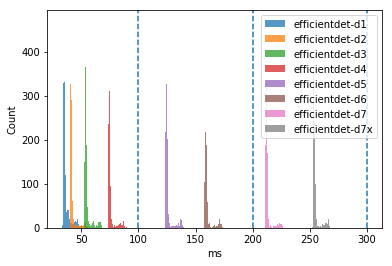

In [34]:
for x in [100, 200, 300]:
    plt.axvline(x=x, linestyle="--")
plt.xlabel("ms")
cmap = plt.get_cmap("tab10")
for i, (d, v) in enumerate(sorted(runtimes.items(), key=lambda x: x[0])):
    sns.histplot(v, label=d, color=cmap(i), linewidth=0)
plt.legend()

### Constructing policies with all models, then just the highest latency models in a frame gap and then the lowest latency models in a frame gap

In [2]:
timely_mota_df = pd.read_parquet("timely_mean_mota_df.pq")

In [3]:
# metric = "T_ratio_mostly_tracked"
metric = "T_mota"

In [4]:
config_space = ConfigSpace(timely_mota_df,
                           scenario_column="run",
                           metric_column="metric",
                           score_column="mean_score",
                           config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"])

In [5]:
oracle_per_scenario_policy = config_space.oracle_per_scenario_policy(metric)

In [6]:
d467x_config_space = ConfigSpace(timely_mota_df[timely_mota_df["D-model"].isin(["efficientdet-d4", "efficientdet-d6", "efficientdet-d7x"])],
                                        scenario_column="run",
                                        metric_column="metric",
                                        score_column="mean_score",
                                        config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"])

In [7]:
d467x_oracle_per_scenario_policy = d467x_config_space.oracle_per_scenario_policy(metric)

In [8]:
d157_config_space = ConfigSpace(timely_mota_df[timely_mota_df["D-model"].isin(["efficientdet-d1", "efficientdet-d5", "efficientdet-d7"])],
                                        scenario_column="run",
                                        metric_column="metric",
                                        score_column="mean_score",
                                        config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"])

In [9]:
d157_oracle_per_scenario_policy = d157_config_space.oracle_per_scenario_policy(metric)

In [11]:
global_static_config_policy = config_space.static_config_policy(metric)
global_static_config_policy[list(global_static_config_policy.keys())[0]]


100%|██████████| 2304/2304 [01:49<00:00, 21.08it/s]


{'D-model': 'efficientdet-d4',
 'D-conf': 0.5,
 'D-seq-pol': 'wait',
 'T-min-iou': 0.1,
 'T-max-age': 5,
 'T-every-nth-det': 1}

scenarios with highest improvement in global static config policy
['training_0002-S2' 'training_0005-S6' 'training_0004-S15'
 'training_0002-S7' 'training_0000-S8']
['training_0001-S1' 'training_0001-S16' 'training_0005-S2'
 'training_0004-S0' 'training_0005-S18']
scenarios with highest improvement in oracle per scenario all models
['training_0001-S18' 'training_0000-S15' 'training_0003-S0'
 'training_0000-S17' 'training_0004-S4']
['training_0000-S19' 'training_0005-S3' 'training_0005-S8'
 'training_0004-S3' 'training_0005-S4']
scenarios with highest improvement in oracle per scenario d4, d6, d7x only
['training_0000-S16' 'training_0001-S19' 'training_0003-S18'
 'training_0004-S4' 'training_0001-S3']
['training_0001-S5' 'training_0005-S3' 'training_0005-S8'
 'training_0004-S3' 'training_0005-S4']
scenarios with highest improvement in oracle per scenario d1, d5, d7 only
['training_0005-S16' 'training_0002-S4' 'training_0000-S20'
 'training_0001-S3' 'training_0003-S4']
['training_0005-S3

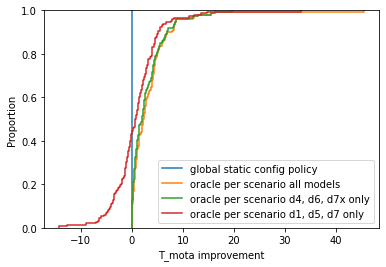

In [12]:
compare_policies(config_space, 
                 [
                     global_static_config_policy, 
                     oracle_per_scenario_policy, 
                     d467x_oracle_per_scenario_policy,
                     d157_oracle_per_scenario_policy
                 ], metric, 
                 [
                     "global static config policy", 
                     "oracle per scenario all models", 
                     "oracle per scenario d4, d6, d7x only",
                     "oracle per scenario d1, d5, d7 only"
                 ]
)